In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image

import torch
from torch.autograd import Variable
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor
import albumentations as A

In [2]:
class CustomOxFordPet(Dataset):
    def __init__(self, root:str = "/media/mountHDD2/oxfordpet", split = 'trainval'):
        self.root = root
        self._split = split

        self.aug_transforms = A.Compose(
            [
                A.Resize(256, 256),
                A.HorizontalFlip(p=0.2),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=3, p=0.5, border_mode = cv2.BORDER_CONSTANT),
            ]
        )

        self.img_transform = A.Compose(
            [
                A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ]
        )

        self._images_folder = self.root + "/images"
        self._anns_folder = self.root + "/annotations"
        self._segs_folder = self._anns_folder + "/trimaps"

        image_ids = []
        self._labels = []
        with open(self._anns_folder + f"/{self._split}.txt") as file:
            for line in file:
                image_id, label, *_ = line.strip().split()
                image_ids.append(image_id)
                self._labels.append(int(label) - 1)

        self.classes = [
            " ".join(part.title() for part in raw_cls.split("_"))
            for raw_cls, _ in sorted(
                {(image_id.rsplit("_", 1)[0], label) for image_id, label in zip(image_ids, self._labels)},
                key=lambda image_id_and_label: image_id_and_label[1],
            )
        ]
        self.class_to_idx = dict(zip(self.classes, range(len(self.classes))))

        self._images = [self._images_folder + f"/{image_id}.jpg" for image_id in image_ids]
        self._segs = [self._segs_folder + f"/{image_id}.png" for image_id in image_ids]

    @staticmethod
    def process_mask(x):
        uniques = torch.unique(x, sorted = True)
        if uniques.shape[0] > 3:
            x[x == 0] = uniques[2]
            uniques = torch.unique(x, sorted = True)
        for i, v in enumerate(uniques):
            x[x == v] = i
        
        x = x.to(dtype=torch.long)
        onehot = F.one_hot(x.squeeze(1), 3).permute(0, 3, 1, 2)[0].float()
        return onehot

    def __len__(self):
        return len(self._images)

    def __getitem__(self, idx): 
        image = np.array(Image.open(self._images[idx]).convert("RGB"))
        
        mask = np.array(Image.open(self._segs[idx]))

        transformed = self.aug_transforms(image = image, mask = mask)
        transformed_img = self.img_transform(image=transformed["image"])["image"]
        transformed_mask = transformed["mask"]

        torch_img = torch.from_numpy(transformed_img).permute(-1, 0, 1).float()
        torch_mask = torch.from_numpy(transformed_mask).unsqueeze(-1).permute(-1, 0, 1).float()

        target = {
            "semantic" : self.process_mask(torch_mask),
            "category" : self._labels[idx],
        }

        return torch_img, target

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3680
3669
Image Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
semantic Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
category: 0


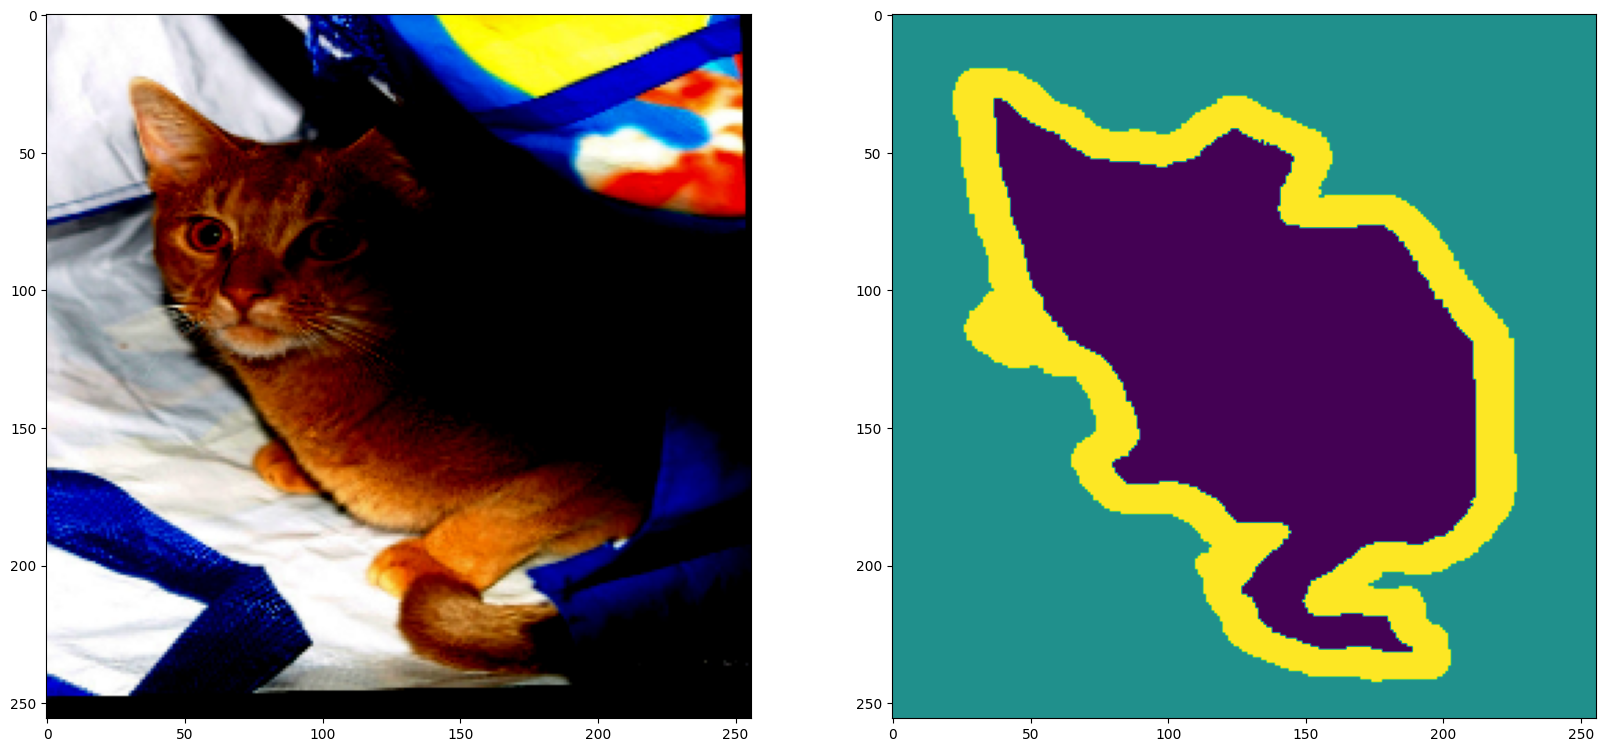

In [3]:
train_ds = CustomOxFordPet(split = 'trainval')
test_ds = CustomOxFordPet(split = 'test')

print(len(train_ds))
print(len(test_ds))

for idx in range(1):
    img, target = train_ds[idx]

    print(f"Image Shape/Dtype: {img.shape}/{img.dtype}")
    for key in target:
        if isinstance(target[key], int):
            print(f"{key}: {target[key]}")
        else:
            print(f"{key} Shape/Dtype: {target[key].shape}/{target[key].dtype}")

    img_np = img.permute(1, -1, 0).numpy()

    f, axarr = plt.subplots(1, 2, figsize=(20, 15))
    axarr[0].imshow(img_np)
    axarr[1].imshow(torch.argmax(target['semantic'], dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [4]:
extra_train_ds, valid_ds, test_ds = random_split(test_ds, [0.8, 0.1, 0.1])

train_ds = ConcatDataset([train_ds, extra_train_ds])

print(f"#Training Samples: {len(train_ds)}")
print(f"#Validating Samples: {len(valid_ds)}")
print(f"#Testing Samples: {len(test_ds)}")

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True, pin_memory=True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True, pin_memory=True, num_workers=24)

print(f"Train Batch Samples: {len(train_dl)}")
print(f"Valid Batch Samples: {len(valid_dl)}")
print(f"Test Batch Samples: {len(test_dl)}")

#Training Samples: 6616
#Validating Samples: 367
#Testing Samples: 366
Train Batch Samples: 104
Valid Batch Samples: 6
Test Batch Samples: 6


In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [6]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [7]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [8]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [9]:
class GlobalAvgPooling(nn.Module):
    def __init__(self):
        super(GlobalAvgPooling, self).__init__()

    def forward(self, x):
        return x.mean(dim=(2, 3))

In [10]:
class OxFordPetUnet(nn.Module):
    def __init__(self, n_channels, seg_n_classes, cls_n_classes, init_ch=32):
        super(OxFordPetUnet, self).__init__()
        self.seg_n_classes = seg_n_classes
        self.cls_n_classes = cls_n_classes
        self.init_ch = init_ch

        self.encoder = nn.Sequential(
            DoubleConv(n_channels, self.init_ch),
            Down(self.init_ch, self.init_ch*2),
            Down(self.init_ch*2, self.init_ch*4),
            Down(self.init_ch*4, self.init_ch*8),
            Down(self.init_ch*8, self.init_ch*16)
        )

        self.encoder = nn.ModuleList(
            [
                DoubleConv(n_channels, self.init_ch),
                Down(self.init_ch, self.init_ch*2),
                Down(self.init_ch*2, self.init_ch*4),
                Down(self.init_ch*4, self.init_ch*8),
                Down(self.init_ch*8, self.init_ch*16)
            ]
        )

        self.decoder = nn.ModuleDict(
            {
                "cls" : nn.Sequential(
                    Down(self.init_ch*16, self.init_ch*24),
                    GlobalAvgPooling(),
                    nn.Linear(self.init_ch*24, 256),
                    nn.ReLU(),
                    nn.Linear(256, self.cls_n_classes)
                ),
                "seg" : nn.ModuleList(
                    [
                        Up(self.init_ch*16, self.init_ch*8),
                        Up(self.init_ch*8, self.init_ch*4),
                        Up(self.init_ch*4, self.init_ch*2),
                        Up(self.init_ch*2, self.init_ch),
                        OutConv(self.init_ch, self.seg_n_classes)
                    ]
                )
            }
        )

    def forward(self, x):
        x1 = self.encoder[0](x)
        x2 = self.encoder[1](x1)
        x3 = self.encoder[2](x2)
        x4 = self.encoder[3](x3)
        x5 = self.encoder[4](x4)
        
        x = self.decoder['seg'][0](x5, x4)
        x = self.decoder['seg'][1](x, x3)
        x = self.decoder['seg'][2](x, x2)
        x = self.decoder['seg'][3](x, x1)
        
        logits = self.decoder['cls'](x5)
        masks = self.decoder['seg'][4](x)
        return logits, masks

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = OxFordPetUnet(n_channels=3, seg_n_classes=3, cls_n_classes=37, init_ch=32).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

cls_loss_fn = nn.CrossEntropyLoss()
seg_loss_fn = nn.CrossEntropyLoss()

In [12]:
for epoch in range(epochs):
    model.train()
    tr_cls_loss = 0
    tr_seg_loss = 0
    tr_cls_corr = 0 
    tr_seg_corr = 0 
    for train_img, train_target in tqdm(train_dl):
        train_img = train_img.to(device)
        train_label_cate = train_target['category'].to(device)
        train_label_mask = train_target['semantic'].to(device)

        train_logits, train_masks = model(train_img)
        
        train_cls_loss = cls_loss_fn(train_logits, train_label_cate)
        train_seg_loss = seg_loss_fn(train_masks, train_label_mask)
        train_loss = train_cls_loss + train_seg_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_cls_loss += train_cls_loss.item()
        tr_seg_loss += train_seg_loss.item()
        
        tr_cls_corr += (train_logits.argmax(dim=1) == train_label_cate).sum().item()
        tr_seg_corr += (train_masks.argmax(dim=1) == train_label_mask.argmax(dim=1)).sum().item() / (256 * 256)

    model.eval()
    with torch.no_grad():
        va_cls_loss = 0
        va_seg_loss = 0
        va_cls_corr = 0
        va_seg_corr = 0 
        for valid_img, valid_target in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_label_cate = valid_target['category'].to(device)
            valid_label_mask = valid_target['semantic'].to(device)
            
            valid_logits, valid_masks = model(valid_img)
            
            valid_cls_loss = cls_loss_fn(valid_logits, valid_label_cate)
            valid_seg_loss = seg_loss_fn(valid_masks, valid_label_mask)

            va_cls_loss += valid_cls_loss.item()
            va_seg_loss += valid_seg_loss.item()
            
            va_cls_corr += (valid_logits.argmax(dim=1) == valid_label_cate).sum().item()
            va_seg_corr += (valid_masks.argmax(dim=1) == valid_label_mask.argmax(dim=1)).sum().item() / (256 * 256)
            
    mean_train_cls_loss = tr_cls_loss/len(train_dl)
    mean_train_seg_loss = tr_seg_loss/len(train_dl)
    mean_valid_cls_loss = va_cls_loss/len(valid_dl)
    mean_valid_seg_loss = va_seg_loss/len(valid_dl)

    mean_train_cls_corr = tr_cls_corr/len(train_ds)
    mean_valid_cls_corr = va_cls_corr/len(valid_ds)

    mean_train_seg_corr = tr_seg_corr/len(train_ds)
    mean_valid_seg_corr = va_seg_corr/len(valid_ds)

    print(f"Epoch: {epoch} - TrainLoss - SegLoss: {mean_train_seg_loss} - ClsLoss: {mean_train_cls_loss}")
    print(f"Epoch: {epoch} - TrainCorr - ClsCorr: {mean_train_cls_corr} - SegCorr: {mean_train_seg_corr}")
    
    print(f"Epoch: {epoch} - ValidLoss - SegLoss: {mean_valid_seg_loss} - ClsLoss: {mean_valid_cls_loss}")
    print(f"Epoch: {epoch} - ValidCorr - ClsCorr: {mean_valid_cls_corr} - SegCorr: {mean_valid_seg_corr}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 0 - TrainLoss - SegLoss: 0.7909127685886163 - ClsLoss: 3.505344012608895
Epoch: 0 - TrainCorr - ClsCorr: 0.05471584038694075 - SegCorr: 0.659229460765834
Epoch: 0 - ValidLoss - SegLoss: 0.748252292474111 - ClsLoss: 3.817158897717794
Epoch: 0 - ValidCorr - ClsCorr: 0.05722070844686648 - SegCorr: 0.6871391525060669


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 1 - TrainLoss - SegLoss: 0.627587245633969 - ClsLoss: 3.305657519743993
Epoch: 1 - TrainCorr - ClsCorr: 0.08313180169286578 - SegCorr: 0.7450310454547333
Epoch: 1 - ValidLoss - SegLoss: 0.6318026681741079 - ClsLoss: 3.27334201335907
Epoch: 1 - ValidCorr - ClsCorr: 0.08991825613079019 - SegCorr: 0.7553012858294661


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s]


Epoch: 2 - TrainLoss - SegLoss: 0.5684221507265017 - ClsLoss: 3.1213650772204766
Epoch: 2 - TrainCorr - ClsCorr: 0.11940749697702539 - SegCorr: 0.7716707462555263
Epoch: 2 - ValidLoss - SegLoss: 0.5327818195025126 - ClsLoss: 3.0653767585754395
Epoch: 2 - ValidCorr - ClsCorr: 0.12534059945504086 - SegCorr: 0.790367521447122


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s]


Epoch: 3 - TrainLoss - SegLoss: 0.5186342637126262 - ClsLoss: 2.9440104892620673
Epoch: 3 - TrainCorr - ClsCorr: 0.15069528415961306 - SegCorr: 0.7946154837740952
Epoch: 3 - ValidLoss - SegLoss: 0.5095024059216181 - ClsLoss: 3.152087370554606
Epoch: 3 - ValidCorr - ClsCorr: 0.16348773841961853 - SegCorr: 0.799451573343303


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]


Epoch: 4 - TrainLoss - SegLoss: 0.4807780935214116 - ClsLoss: 2.7193943170400767
Epoch: 4 - TrainCorr - ClsCorr: 0.20873639661426843 - SegCorr: 0.8107674263120418
Epoch: 4 - ValidLoss - SegLoss: 0.4895877291758855 - ClsLoss: 3.099712530771891
Epoch: 4 - ValidCorr - ClsCorr: 0.1771117166212534 - SegCorr: 0.8065565977174515


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.55it/s]


Epoch: 5 - TrainLoss - SegLoss: 0.4553777681520352 - ClsLoss: 2.531346245453908
Epoch: 5 - TrainCorr - ClsCorr: 0.253627569528416 - SegCorr: 0.8211351092521917
Epoch: 5 - ValidLoss - SegLoss: 0.4856904447078705 - ClsLoss: 3.1585353215535483
Epoch: 5 - ValidCorr - ClsCorr: 0.16893732970027248 - SegCorr: 0.807969802731714


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 6 - TrainLoss - SegLoss: 0.436944843771366 - ClsLoss: 2.3380830643268733
Epoch: 6 - TrainCorr - ClsCorr: 0.2967049576783555 - SegCorr: 0.8289081292112044
Epoch: 6 - ValidLoss - SegLoss: 0.40158826609452564 - ClsLoss: 2.5211292107899985
Epoch: 6 - ValidCorr - ClsCorr: 0.2561307901907357 - SegCorr: 0.8434767138405782


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s]


Epoch: 7 - TrainLoss - SegLoss: 0.4175755504805308 - ClsLoss: 2.167621163221506
Epoch: 7 - TrainCorr - ClsCorr: 0.34552599758162034 - SegCorr: 0.8362303783412135
Epoch: 7 - ValidLoss - SegLoss: 0.43725227812925976 - ClsLoss: 2.7062493562698364
Epoch: 7 - ValidCorr - ClsCorr: 0.24795640326975477 - SegCorr: 0.8309927792250298


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 8 - TrainLoss - SegLoss: 0.40174160811763543 - ClsLoss: 2.0397559369985876
Epoch: 8 - TrainCorr - ClsCorr: 0.3854292623941959 - SegCorr: 0.843112721841021
Epoch: 8 - ValidLoss - SegLoss: 0.4289042005936305 - ClsLoss: 2.5414080222447715
Epoch: 8 - ValidCorr - ClsCorr: 0.3106267029972752 - SegCorr: 0.834881982621445


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 9 - TrainLoss - SegLoss: 0.39215607052812207 - ClsLoss: 1.8834839658095286
Epoch: 9 - TrainCorr - ClsCorr: 0.4244256348246675 - SegCorr: 0.8467508198416362
Epoch: 9 - ValidLoss - SegLoss: 0.3929974486430486 - ClsLoss: 2.0859285791714988
Epoch: 9 - ValidCorr - ClsCorr: 0.3760217983651226 - SegCorr: 0.8466179871104393


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 10 - TrainLoss - SegLoss: 0.38661384467895216 - ClsLoss: 1.744272796007303
Epoch: 10 - TrainCorr - ClsCorr: 0.4563180169286578 - SegCorr: 0.8496984322673609
Epoch: 10 - ValidLoss - SegLoss: 0.3732472558816274 - ClsLoss: 2.798841436704
Epoch: 10 - ValidCorr - ClsCorr: 0.28337874659400547 - SegCorr: 0.8562118987621339


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 11 - TrainLoss - SegLoss: 0.36893014208628583 - ClsLoss: 1.5959489047527313
Epoch: 11 - TrainCorr - ClsCorr: 0.49788391777509067 - SegCorr: 0.8565498707228156
Epoch: 11 - ValidLoss - SegLoss: 0.36779871582984924 - ClsLoss: 2.2055606047312417
Epoch: 11 - ValidCorr - ClsCorr: 0.3024523160762943 - SegCorr: 0.8575481861748553


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s]


Epoch: 12 - TrainLoss - SegLoss: 0.35425354540348053 - ClsLoss: 1.4794602611890206
Epoch: 12 - TrainCorr - ClsCorr: 0.5255441354292624 - SegCorr: 0.8624087867598436
Epoch: 12 - ValidLoss - SegLoss: 0.38931649923324585 - ClsLoss: 1.7719510595003765
Epoch: 12 - ValidCorr - ClsCorr: 0.4604904632152589 - SegCorr: 0.8478098773176729


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 13 - TrainLoss - SegLoss: 0.3491388221199696 - ClsLoss: 1.3380355175871115
Epoch: 13 - TrainCorr - ClsCorr: 0.5751209189842805 - SegCorr: 0.8646827245709974
Epoch: 13 - ValidLoss - SegLoss: 0.34703329205513 - ClsLoss: 1.8304773569107056
Epoch: 13 - ValidCorr - ClsCorr: 0.4141689373297003 - SegCorr: 0.8638913105229266


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s]


Epoch: 14 - TrainLoss - SegLoss: 0.3388167006465105 - ClsLoss: 1.2162826783381975
Epoch: 14 - TrainCorr - ClsCorr: 0.6036880290205562 - SegCorr: 0.8687932061745437
Epoch: 14 - ValidLoss - SegLoss: 0.3313623716433843 - ClsLoss: 2.6005680163701377
Epoch: 14 - ValidCorr - ClsCorr: 0.35967302452316074 - SegCorr: 0.871271990950166


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 15 - TrainLoss - SegLoss: 0.32829615330466855 - ClsLoss: 1.1551834780436296
Epoch: 15 - TrainCorr - ClsCorr: 0.6260580411124547 - SegCorr: 0.8727158865876757
Epoch: 15 - ValidLoss - SegLoss: 0.324826642870903 - ClsLoss: 1.7429532210032146
Epoch: 15 - ValidCorr - ClsCorr: 0.49591280653950953 - SegCorr: 0.8730551488393009


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 16 - TrainLoss - SegLoss: 0.3290305762336804 - ClsLoss: 1.0639208887632077
Epoch: 16 - TrainCorr - ClsCorr: 0.6508464328899637 - SegCorr: 0.872813910930592
Epoch: 16 - ValidLoss - SegLoss: 0.3831656227509181 - ClsLoss: 1.7749660015106201
Epoch: 16 - ValidCorr - ClsCorr: 0.45231607629427795 - SegCorr: 0.8533260335064714


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s]


Epoch: 17 - TrainLoss - SegLoss: 0.3205048648210672 - ClsLoss: 0.970277165564207
Epoch: 17 - TrainCorr - ClsCorr: 0.6756348246674728 - SegCorr: 0.8755914602775527
Epoch: 17 - ValidLoss - SegLoss: 0.31417228281497955 - ClsLoss: 1.9185781677563984
Epoch: 17 - ValidCorr - ClsCorr: 0.4768392370572207 - SegCorr: 0.878833074335831


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 18 - TrainLoss - SegLoss: 0.31227504633940184 - ClsLoss: 0.9165026872203901
Epoch: 18 - TrainCorr - ClsCorr: 0.6989117291414753 - SegCorr: 0.879254612121213
Epoch: 18 - ValidLoss - SegLoss: 0.30709977944691974 - ClsLoss: 1.5875688195228577
Epoch: 18 - ValidCorr - ClsCorr: 0.5422343324250681 - SegCorr: 0.8813779243656336


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 19 - TrainLoss - SegLoss: 0.30876509415415615 - ClsLoss: 0.8429587165323588
Epoch: 19 - TrainCorr - ClsCorr: 0.7268742442563483 - SegCorr: 0.8808843642653404
Epoch: 19 - ValidLoss - SegLoss: 0.30229509870211285 - ClsLoss: 1.2413214941819508
Epoch: 19 - ValidCorr - ClsCorr: 0.6103542234332425 - SegCorr: 0.8817480435488334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s]


Epoch: 20 - TrainLoss - SegLoss: 0.30200334910589915 - ClsLoss: 0.798885142000822
Epoch: 20 - TrainCorr - ClsCorr: 0.7298972188633616 - SegCorr: 0.8837756949151442
Epoch: 20 - ValidLoss - SegLoss: 0.2973107397556305 - ClsLoss: 1.3008493185043335
Epoch: 20 - ValidCorr - ClsCorr: 0.6130790190735694 - SegCorr: 0.8843507272995785


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s]


Epoch: 21 - TrainLoss - SegLoss: 0.3005906185851647 - ClsLoss: 0.7459192187167131
Epoch: 21 - TrainCorr - ClsCorr: 0.749093107617896 - SegCorr: 0.883722932624125
Epoch: 21 - ValidLoss - SegLoss: 0.31439168254534405 - ClsLoss: 1.4740479985872905
Epoch: 21 - ValidCorr - ClsCorr: 0.5449591280653951 - SegCorr: 0.8756109336416468


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 22 - TrainLoss - SegLoss: 0.3006265676365449 - ClsLoss: 0.6992704773751589
Epoch: 22 - TrainCorr - ClsCorr: 0.7640568319226119 - SegCorr: 0.8842737250921948
Epoch: 22 - ValidLoss - SegLoss: 0.2786390980084737 - ClsLoss: 1.4437973896662395
Epoch: 22 - ValidCorr - ClsCorr: 0.55858310626703 - SegCorr: 0.8914998649576379


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.42it/s]


Epoch: 23 - TrainLoss - SegLoss: 0.2887674065736624 - ClsLoss: 0.6206159001359572
Epoch: 23 - TrainCorr - ClsCorr: 0.7886940749697703 - SegCorr: 0.8885018995624067
Epoch: 23 - ValidLoss - SegLoss: 0.2765521953503291 - ClsLoss: 1.537439227104187
Epoch: 23 - ValidCorr - ClsCorr: 0.5367847411444142 - SegCorr: 0.8927228548221432


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s]


Epoch: 24 - TrainLoss - SegLoss: 0.2871860335939206 - ClsLoss: 0.5919081729192001
Epoch: 24 - TrainCorr - ClsCorr: 0.7988210399032648 - SegCorr: 0.8894308083290922
Epoch: 24 - ValidLoss - SegLoss: 0.27942757805188495 - ClsLoss: 1.4057105779647827
Epoch: 24 - ValidCorr - ClsCorr: 0.6130790190735694 - SegCorr: 0.890607080277695


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.41it/s]


Epoch: 25 - TrainLoss - SegLoss: 0.28381059419077176 - ClsLoss: 0.5758882265251416
Epoch: 25 - TrainCorr - ClsCorr: 0.8048669891172914 - SegCorr: 0.8907370123350058
Epoch: 25 - ValidLoss - SegLoss: 0.28034624457359314 - ClsLoss: 1.3778639435768127
Epoch: 25 - ValidCorr - ClsCorr: 0.6076294277929155 - SegCorr: 0.8913132254369253


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.39it/s]


Epoch: 26 - TrainLoss - SegLoss: 0.2818515862409885 - ClsLoss: 0.5425928951455996
Epoch: 26 - TrainCorr - ClsCorr: 0.8187726723095526 - SegCorr: 0.8912156576689382
Epoch: 26 - ValidLoss - SegLoss: 0.2793174535036087 - ClsLoss: 1.2079719702402751
Epoch: 26 - ValidCorr - ClsCorr: 0.6784741144414169 - SegCorr: 0.8930076994103372


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]


Epoch: 27 - TrainLoss - SegLoss: 0.27587568000532114 - ClsLoss: 0.4770620105644831
Epoch: 27 - TrainCorr - ClsCorr: 0.840689238210399 - SegCorr: 0.8932471638579178
Epoch: 27 - ValidLoss - SegLoss: 0.2664106736580531 - ClsLoss: 1.1798198620478313
Epoch: 27 - ValidCorr - ClsCorr: 0.6648501362397821 - SegCorr: 0.8962942845814884


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 28 - TrainLoss - SegLoss: 0.27241963205429226 - ClsLoss: 0.4461009536798184
Epoch: 28 - TrainCorr - ClsCorr: 0.8477932285368803 - SegCorr: 0.894960754007065
Epoch: 28 - ValidLoss - SegLoss: 0.272663692633311 - ClsLoss: 1.2295342087745667
Epoch: 28 - ValidCorr - ClsCorr: 0.6485013623978202 - SegCorr: 0.8950398208659741


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 29 - TrainLoss - SegLoss: 0.2730689449952199 - ClsLoss: 0.4225294224631328
Epoch: 29 - TrainCorr - ClsCorr: 0.8577690447400241 - SegCorr: 0.8939750699062878
Epoch: 29 - ValidLoss - SegLoss: 0.28979316850503284 - ClsLoss: 1.3143675327301025
Epoch: 29 - ValidCorr - ClsCorr: 0.6485013623978202 - SegCorr: 0.8870639229340515


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 30 - TrainLoss - SegLoss: 0.26698576057186496 - ClsLoss: 0.3682490615890576
Epoch: 30 - TrainCorr - ClsCorr: 0.875906892382104 - SegCorr: 0.8967298463869844
Epoch: 30 - ValidLoss - SegLoss: 0.27257539331912994 - ClsLoss: 1.6166530847549438
Epoch: 30 - ValidCorr - ClsCorr: 0.6267029972752044 - SegCorr: 0.8936793355915786


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s]


Epoch: 31 - TrainLoss - SegLoss: 0.26688537273842555 - ClsLoss: 0.36450628062280327
Epoch: 31 - TrainCorr - ClsCorr: 0.8774183796856106 - SegCorr: 0.8975102771726744
Epoch: 31 - ValidLoss - SegLoss: 0.2688708653052648 - ClsLoss: 1.2045605679353077
Epoch: 31 - ValidCorr - ClsCorr: 0.6185286103542235 - SegCorr: 0.8958741065916638


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s]


Epoch: 32 - TrainLoss - SegLoss: 0.2630909245747786 - ClsLoss: 0.34353570439494574
Epoch: 32 - TrainCorr - ClsCorr: 0.8849758162031439 - SegCorr: 0.898450254096662
Epoch: 32 - ValidLoss - SegLoss: 0.27724121510982513 - ClsLoss: 1.2346094747384389
Epoch: 32 - ValidCorr - ClsCorr: 0.6512261580381471 - SegCorr: 0.8944700069583404


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 33 - TrainLoss - SegLoss: 0.2604643931755653 - ClsLoss: 0.31594973666450155
Epoch: 33 - TrainCorr - ClsCorr: 0.8887545344619106 - SegCorr: 0.8992698212776968
Epoch: 33 - ValidLoss - SegLoss: 0.28240421662727994 - ClsLoss: 1.15554012854894
Epoch: 33 - ValidCorr - ClsCorr: 0.6784741144414169 - SegCorr: 0.8912943494417362


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 34 - TrainLoss - SegLoss: 0.2597540243027302 - ClsLoss: 0.28337354191507286
Epoch: 34 - TrainCorr - ClsCorr: 0.9046251511487303 - SegCorr: 0.8994032434281299
Epoch: 34 - ValidLoss - SegLoss: 0.2616763363281886 - ClsLoss: 1.1301325956980388
Epoch: 34 - ValidCorr - ClsCorr: 0.6757493188010899 - SegCorr: 0.8979100947159188


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 35 - TrainLoss - SegLoss: 0.2529761590636693 - ClsLoss: 0.26749006214623267
Epoch: 35 - TrainCorr - ClsCorr: 0.9132406287787183 - SegCorr: 0.9025397110446621
Epoch: 35 - ValidLoss - SegLoss: 0.26962214708328247 - ClsLoss: 1.081045498450597
Epoch: 35 - ValidCorr - ClsCorr: 0.7002724795640327 - SegCorr: 0.8952107442497232


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.44it/s]


Epoch: 36 - TrainLoss - SegLoss: 0.25127357702988845 - ClsLoss: 0.265197503595398
Epoch: 36 - TrainCorr - ClsCorr: 0.9096130592503023 - SegCorr: 0.902950102357507
Epoch: 36 - ValidLoss - SegLoss: 0.2530878782272339 - ClsLoss: 1.0287521680196126
Epoch: 36 - ValidCorr - ClsCorr: 0.6948228882833788 - SegCorr: 0.9018353870194354


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.42it/s]


Epoch: 37 - TrainLoss - SegLoss: 0.24791265064134047 - ClsLoss: 0.22898862983744878
Epoch: 37 - TrainCorr - ClsCorr: 0.9245767835550182 - SegCorr: 0.9041898605180623
Epoch: 37 - ValidLoss - SegLoss: 0.24644195040067038 - ClsLoss: 1.1088300943374634
Epoch: 37 - ValidCorr - ClsCorr: 0.7356948228882834 - SegCorr: 0.9049908796513113


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 38 - TrainLoss - SegLoss: 0.24793660511764196 - ClsLoss: 0.2147647555774221
Epoch: 38 - TrainCorr - ClsCorr: 0.9262394195888755 - SegCorr: 0.9042233302198269
Epoch: 38 - ValidLoss - SegLoss: 0.2540905276934306 - ClsLoss: 1.305430789788564
Epoch: 38 - ValidCorr - ClsCorr: 0.6811989100817438 - SegCorr: 0.9009090080573059


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 39 - TrainLoss - SegLoss: 0.2474802564829588 - ClsLoss: 0.22075511593944752
Epoch: 39 - TrainCorr - ClsCorr: 0.9291112454655381 - SegCorr: 0.9045241400869755
Epoch: 39 - ValidLoss - SegLoss: 0.24867858241001764 - ClsLoss: 1.256224016348521
Epoch: 39 - ValidCorr - ClsCorr: 0.7084468664850136 - SegCorr: 0.9035017964625554


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s]


Epoch: 40 - TrainLoss - SegLoss: 0.24612672669956318 - ClsLoss: 0.1908909699593026
Epoch: 40 - TrainCorr - ClsCorr: 0.9351571946795647 - SegCorr: 0.9051570431064666
Epoch: 40 - ValidLoss - SegLoss: 0.2534804667035739 - ClsLoss: 1.099379986524582
Epoch: 40 - ValidCorr - ClsCorr: 0.6784741144414169 - SegCorr: 0.901650535313245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]


Epoch: 41 - TrainLoss - SegLoss: 0.2400441267169439 - ClsLoss: 0.17927455654940927
Epoch: 41 - TrainCorr - ClsCorr: 0.9425634824667473 - SegCorr: 0.9073023859506074
Epoch: 41 - ValidLoss - SegLoss: 0.25189315030972165 - ClsLoss: 1.0815228720506032
Epoch: 41 - ValidCorr - ClsCorr: 0.7002724795640327 - SegCorr: 0.903090266505769


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 42 - TrainLoss - SegLoss: 0.24140265440711609 - ClsLoss: 0.1818742250593809
Epoch: 42 - TrainCorr - ClsCorr: 0.9405985489721886 - SegCorr: 0.9069502921606062
Epoch: 42 - ValidLoss - SegLoss: 0.2468095893661181 - ClsLoss: 1.3202586968739827
Epoch: 42 - ValidCorr - ClsCorr: 0.6376021798365122 - SegCorr: 0.9036745492379087


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s]


Epoch: 43 - TrainLoss - SegLoss: 0.23725533342132202 - ClsLoss: 0.1744878701507472
Epoch: 43 - TrainCorr - ClsCorr: 0.9416565900846433 - SegCorr: 0.9081609280827256
Epoch: 43 - ValidLoss - SegLoss: 0.25253815203905106 - ClsLoss: 1.1729495724042256
Epoch: 43 - ValidCorr - ClsCorr: 0.7002724795640327 - SegCorr: 0.9026083465493018


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]


Epoch: 44 - TrainLoss - SegLoss: 0.23557099098196396 - ClsLoss: 0.13339273266207713
Epoch: 44 - TrainCorr - ClsCorr: 0.9590386940749698 - SegCorr: 0.9088904093658189
Epoch: 44 - ValidLoss - SegLoss: 0.2584463680783908 - ClsLoss: 0.9886753559112549
Epoch: 44 - ValidCorr - ClsCorr: 0.7438692098092643 - SegCorr: 0.9007027025768477


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s]


Epoch: 45 - TrainLoss - SegLoss: 0.23555413934473807 - ClsLoss: 0.14466819948015305
Epoch: 45 - TrainCorr - ClsCorr: 0.9529927448609432 - SegCorr: 0.9094861294655299
Epoch: 45 - ValidLoss - SegLoss: 0.24377818902333578 - ClsLoss: 1.2037128607432048
Epoch: 45 - ValidCorr - ClsCorr: 0.7220708446866485 - SegCorr: 0.9042826140609035


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 46 - TrainLoss - SegLoss: 0.23279507759098822 - ClsLoss: 0.1295813203860934
Epoch: 46 - TrainCorr - ClsCorr: 0.9578295042321644 - SegCorr: 0.910162490973882
Epoch: 46 - ValidLoss - SegLoss: 0.2510189985235532 - ClsLoss: 1.22642183303833
Epoch: 46 - ValidCorr - ClsCorr: 0.7166212534059946 - SegCorr: 0.9021195663743188


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 47 - TrainLoss - SegLoss: 0.22850271500647068 - ClsLoss: 0.12698400489842662
Epoch: 47 - TrainCorr - ClsCorr: 0.9584340991535671 - SegCorr: 0.9114975566010666
Epoch: 47 - ValidLoss - SegLoss: 0.24085868149995804 - ClsLoss: 1.2659083505471547
Epoch: 47 - ValidCorr - ClsCorr: 0.7084468664850136 - SegCorr: 0.9066349206243614


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]


Epoch: 48 - TrainLoss - SegLoss: 0.22735798803086466 - ClsLoss: 0.10910853534005582
Epoch: 48 - TrainCorr - ClsCorr: 0.9646311970979444 - SegCorr: 0.9121458152761771
Epoch: 48 - ValidLoss - SegLoss: 0.24349171419938406 - ClsLoss: 1.0779236455758412
Epoch: 48 - ValidCorr - ClsCorr: 0.7057220708446866 - SegCorr: 0.9065704345703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 49 - TrainLoss - SegLoss: 0.22444426827132702 - ClsLoss: 0.10768453212669836
Epoch: 49 - TrainCorr - ClsCorr: 0.9649334945586457 - SegCorr: 0.9135359541536675
Epoch: 49 - ValidLoss - SegLoss: 0.23986878991127014 - ClsLoss: 1.0707848072052002
Epoch: 49 - ValidCorr - ClsCorr: 0.7520435967302452 - SegCorr: 0.907070066363675


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 50 - TrainLoss - SegLoss: 0.22176514508632514 - ClsLoss: 0.0918019197594661
Epoch: 50 - TrainCorr - ClsCorr: 0.9718863361547763 - SegCorr: 0.9141347785958932
Epoch: 50 - ValidLoss - SegLoss: 0.23554126173257828 - ClsLoss: 1.0743325750033061
Epoch: 50 - ValidCorr - ClsCorr: 0.7493188010899182 - SegCorr: 0.9083651924653015


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 51 - TrainLoss - SegLoss: 0.22148786055353972 - ClsLoss: 0.09947606611352128
Epoch: 51 - TrainCorr - ClsCorr: 0.966596130592503 - SegCorr: 0.914750056514717
Epoch: 51 - ValidLoss - SegLoss: 0.2417381008466085 - ClsLoss: 1.2467594643433888
Epoch: 51 - ValidCorr - ClsCorr: 0.7302452316076294 - SegCorr: 0.9073038127181965


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]


Epoch: 52 - TrainLoss - SegLoss: 0.21715404809667513 - ClsLoss: 0.08375134530405585
Epoch: 52 - TrainCorr - ClsCorr: 0.9741535671100363 - SegCorr: 0.9158629886760965
Epoch: 52 - ValidLoss - SegLoss: 0.23371783892313638 - ClsLoss: 1.1675212581952412
Epoch: 52 - ValidCorr - ClsCorr: 0.7166212534059946 - SegCorr: 0.9098255874675366


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s]


Epoch: 53 - TrainLoss - SegLoss: 0.21759547880635813 - ClsLoss: 0.08018347912897858
Epoch: 53 - TrainCorr - ClsCorr: 0.9753627569528416 - SegCorr: 0.9158031551264217
Epoch: 53 - ValidLoss - SegLoss: 0.23554530243078867 - ClsLoss: 1.1510859330495198
Epoch: 53 - ValidCorr - ClsCorr: 0.7574931880108992 - SegCorr: 0.9080859607831658


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 54 - TrainLoss - SegLoss: 0.21240596673809564 - ClsLoss: 0.07729032297636597
Epoch: 54 - TrainCorr - ClsCorr: 0.9776299879081015 - SegCorr: 0.9176408705428837
Epoch: 54 - ValidLoss - SegLoss: 0.23748415460189184 - ClsLoss: 1.1053056418895721
Epoch: 54 - ValidCorr - ClsCorr: 0.7302452316076294 - SegCorr: 0.9079848453199506


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 55 - TrainLoss - SegLoss: 0.2133080831800516 - ClsLoss: 0.0679508819594048
Epoch: 55 - TrainCorr - ClsCorr: 0.9770253929866989 - SegCorr: 0.9175790904366841
Epoch: 55 - ValidLoss - SegLoss: 0.24345874538024267 - ClsLoss: 1.0398606757322948
Epoch: 55 - ValidCorr - ClsCorr: 0.7520435967302452 - SegCorr: 0.9071360491926729


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 56 - TrainLoss - SegLoss: 0.212255810172512 - ClsLoss: 0.06423609729748793
Epoch: 56 - TrainCorr - ClsCorr: 0.9808041112454655 - SegCorr: 0.9183864731886655
Epoch: 56 - ValidLoss - SegLoss: 0.23698293914397559 - ClsLoss: 1.1109956800937653
Epoch: 56 - ValidCorr - ClsCorr: 0.7493188010899182 - SegCorr: 0.9095869350173493


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]


Epoch: 57 - TrainLoss - SegLoss: 0.20603305330643287 - ClsLoss: 0.04939767584885256
Epoch: 57 - TrainCorr - ClsCorr: 0.9839782345828295 - SegCorr: 0.9199530152917053
Epoch: 57 - ValidLoss - SegLoss: 0.2267801289757093 - ClsLoss: 0.9996936917304993
Epoch: 57 - ValidCorr - ClsCorr: 0.7683923705722071 - SegCorr: 0.9128078283990761


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 58 - TrainLoss - SegLoss: 0.2047323127492116 - ClsLoss: 0.04605284596730668
Epoch: 58 - TrainCorr - ClsCorr: 0.9877569528415961 - SegCorr: 0.9204404039855736
Epoch: 58 - ValidLoss - SegLoss: 0.23364441841840744 - ClsLoss: 1.141573558251063
Epoch: 58 - ValidCorr - ClsCorr: 0.7547683923705722 - SegCorr: 0.9104091633892839


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 59 - TrainLoss - SegLoss: 0.20177713194145605 - ClsLoss: 0.047021290533638634
Epoch: 59 - TrainCorr - ClsCorr: 0.9873035066505441 - SegCorr: 0.9214230437088474
Epoch: 59 - ValidLoss - SegLoss: 0.23636739452679953 - ClsLoss: 1.1208747227986653
Epoch: 59 - ValidCorr - ClsCorr: 0.7520435967302452 - SegCorr: 0.908555282883813


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 60 - TrainLoss - SegLoss: 0.20139566708642703 - ClsLoss: 0.04321200578795889
Epoch: 60 - TrainCorr - ClsCorr: 0.9866989117291415 - SegCorr: 0.921645712247062
Epoch: 60 - ValidLoss - SegLoss: 0.23418057213226953 - ClsLoss: 1.051140119632085
Epoch: 60 - ValidCorr - ClsCorr: 0.7683923705722071 - SegCorr: 0.9098717796055432


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 61 - TrainLoss - SegLoss: 0.2004287873323147 - ClsLoss: 0.045865004940424114
Epoch: 61 - TrainCorr - ClsCorr: 0.9856408706166868 - SegCorr: 0.9222322461682911
Epoch: 61 - ValidLoss - SegLoss: 0.22702401131391525 - ClsLoss: 1.0889429052670796
Epoch: 61 - ValidCorr - ClsCorr: 0.7629427792915532 - SegCorr: 0.9121253821765369


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s]


Epoch: 62 - TrainLoss - SegLoss: 0.19912413908885077 - ClsLoss: 0.04231279633509425
Epoch: 62 - TrainCorr - ClsCorr: 0.9871523579201935 - SegCorr: 0.9224462751321666
Epoch: 62 - ValidLoss - SegLoss: 0.22740194698174795 - ClsLoss: 1.0459198156992595
Epoch: 62 - ValidCorr - ClsCorr: 0.7656675749318801 - SegCorr: 0.9122502381535252


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 63 - TrainLoss - SegLoss: 0.19652737834705755 - ClsLoss: 0.027590102285522826
Epoch: 63 - TrainCorr - ClsCorr: 0.9931983071342201 - SegCorr: 0.9234446279947818
Epoch: 63 - ValidLoss - SegLoss: 0.23350472996632257 - ClsLoss: 0.9708956281344095
Epoch: 63 - ValidCorr - ClsCorr: 0.776566757493188 - SegCorr: 0.9104347332946611


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.40it/s]


Epoch: 64 - TrainLoss - SegLoss: 0.1938787138519379 - ClsLoss: 0.03004728929282954
Epoch: 64 - TrainCorr - ClsCorr: 0.9928960096735188 - SegCorr: 0.924375171961202
Epoch: 64 - ValidLoss - SegLoss: 0.22944516191879907 - ClsLoss: 0.9891528785228729
Epoch: 64 - ValidCorr - ClsCorr: 0.784741144414169 - SegCorr: 0.9123126453534783


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 65 - TrainLoss - SegLoss: 0.1954940169189985 - ClsLoss: 0.035511397715219155
Epoch: 65 - TrainCorr - ClsCorr: 0.9886638452237001 - SegCorr: 0.923992837354667
Epoch: 65 - ValidLoss - SegLoss: 0.2369242732723554 - ClsLoss: 1.173618992169698
Epoch: 65 - ValidCorr - ClsCorr: 0.7574931880108992 - SegCorr: 0.90944706971379


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.55it/s]


Epoch: 66 - TrainLoss - SegLoss: 0.19148060134970224 - ClsLoss: 0.035583146657490246
Epoch: 66 - TrainCorr - ClsCorr: 0.9894195888754534 - SegCorr: 0.9254395117062034
Epoch: 66 - ValidLoss - SegLoss: 0.23770717531442642 - ClsLoss: 1.0981415112813313
Epoch: 66 - ValidCorr - ClsCorr: 0.7574931880108992 - SegCorr: 0.9104674960352095


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]


Epoch: 67 - TrainLoss - SegLoss: 0.18990570564682668 - ClsLoss: 0.027714370960333887
Epoch: 67 - TrainCorr - ClsCorr: 0.9904776299879081 - SegCorr: 0.9258946138541095
Epoch: 67 - ValidLoss - SegLoss: 0.23161987215280533 - ClsLoss: 1.063133289416631
Epoch: 67 - ValidCorr - ClsCorr: 0.771117166212534 - SegCorr: 0.9109499980708234


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 68 - TrainLoss - SegLoss: 0.18983369693160057 - ClsLoss: 0.024209457210068088
Epoch: 68 - TrainCorr - ClsCorr: 0.9935006045949214 - SegCorr: 0.9265348349113418
Epoch: 68 - ValidLoss - SegLoss: 0.22528907656669617 - ClsLoss: 1.0706788500150044
Epoch: 68 - ValidCorr - ClsCorr: 0.7602179836512262 - SegCorr: 0.9143427711091834


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.55it/s]


Epoch: 69 - TrainLoss - SegLoss: 0.18804393536769426 - ClsLoss: 0.023484754073881328
Epoch: 69 - TrainCorr - ClsCorr: 0.9938029020556227 - SegCorr: 0.9269496636350325
Epoch: 69 - ValidLoss - SegLoss: 0.23079964021841684 - ClsLoss: 1.070564200480779
Epoch: 69 - ValidCorr - ClsCorr: 0.7520435967302452 - SegCorr: 0.9118024114042277


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 70 - TrainLoss - SegLoss: 0.185143242088648 - ClsLoss: 0.015180312811235826
Epoch: 70 - TrainCorr - ClsCorr: 0.9966747279322854 - SegCorr: 0.9280334689452829
Epoch: 70 - ValidLoss - SegLoss: 0.22290524592002234 - ClsLoss: 1.0950977504253387
Epoch: 70 - ValidCorr - ClsCorr: 0.773841961852861 - SegCorr: 0.914793466677133


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 71 - TrainLoss - SegLoss: 0.18439837015019014 - ClsLoss: 0.021109856933785174
Epoch: 71 - TrainCorr - ClsCorr: 0.9935006045949214 - SegCorr: 0.9279006764274699
Epoch: 71 - ValidLoss - SegLoss: 0.23344052582979202 - ClsLoss: 1.0148702561855316
Epoch: 71 - ValidCorr - ClsCorr: 0.7874659400544959 - SegCorr: 0.9126114182641136


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s]


Epoch: 72 - TrainLoss - SegLoss: 0.18388298354469812 - ClsLoss: 0.024429019900988072
Epoch: 72 - TrainCorr - ClsCorr: 0.9945586457073761 - SegCorr: 0.928437141870501
Epoch: 72 - ValidLoss - SegLoss: 0.2304957459370295 - ClsLoss: 0.9825463593006134
Epoch: 72 - ValidCorr - ClsCorr: 0.8038147138964578 - SegCorr: 0.9121729047811649


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 73 - TrainLoss - SegLoss: 0.18482273286924913 - ClsLoss: 0.02494785720661569
Epoch: 73 - TrainCorr - ClsCorr: 0.992744860943168 - SegCorr: 0.9280608406666545
Epoch: 73 - ValidLoss - SegLoss: 0.23310991624991098 - ClsLoss: 1.0654176672299702
Epoch: 73 - ValidCorr - ClsCorr: 0.7574931880108992 - SegCorr: 0.9122272044501447


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.36it/s]


Epoch: 74 - TrainLoss - SegLoss: 0.18432886640612894 - ClsLoss: 0.018500512085246064
Epoch: 74 - TrainCorr - ClsCorr: 0.9953143893591294 - SegCorr: 0.9281884462109788
Epoch: 74 - ValidLoss - SegLoss: 0.22612596799929938 - ClsLoss: 1.0776176303625107
Epoch: 74 - ValidCorr - ClsCorr: 0.776566757493188 - SegCorr: 0.9140486548317226


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 75 - TrainLoss - SegLoss: 0.17914161100410497 - ClsLoss: 0.017974669108158335
Epoch: 75 - TrainCorr - ClsCorr: 0.9957678355501813 - SegCorr: 0.9298303343508811
Epoch: 75 - ValidLoss - SegLoss: 0.22464425613482794 - ClsLoss: 1.0076018273830414
Epoch: 75 - ValidCorr - ClsCorr: 0.784741144414169 - SegCorr: 0.9139666648261878


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 76 - TrainLoss - SegLoss: 0.1786580143066553 - ClsLoss: 0.017487710725757867
Epoch: 76 - TrainCorr - ClsCorr: 0.997279322853688 - SegCorr: 0.9301027992183958
Epoch: 76 - ValidLoss - SegLoss: 0.22974122563997904 - ClsLoss: 1.0800361931324005
Epoch: 76 - ValidCorr - ClsCorr: 0.776566757493188 - SegCorr: 0.9133134472922343


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.41it/s]


Epoch: 77 - TrainLoss - SegLoss: 0.17942143905048186 - ClsLoss: 0.014237449558165211
Epoch: 77 - TrainCorr - ClsCorr: 0.9969770253929867 - SegCorr: 0.9299631660765864
Epoch: 77 - ValidLoss - SegLoss: 0.2271973341703415 - ClsLoss: 1.072160671154658
Epoch: 77 - ValidCorr - ClsCorr: 0.776566757493188 - SegCorr: 0.9138791034916766


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.40it/s]


Epoch: 78 - TrainLoss - SegLoss: 0.17574654791790706 - ClsLoss: 0.011519291157198425
Epoch: 78 - TrainCorr - ClsCorr: 0.9980350665054414 - SegCorr: 0.9311614376746181
Epoch: 78 - ValidLoss - SegLoss: 0.2252697174747785 - ClsLoss: 0.966422309478124
Epoch: 78 - ValidCorr - ClsCorr: 0.7956403269754768 - SegCorr: 0.9150703284655994


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 79 - TrainLoss - SegLoss: 0.17684261242930704 - ClsLoss: 0.010347768913421672
Epoch: 79 - TrainCorr - ClsCorr: 0.9978839177750907 - SegCorr: 0.9309669619171622
Epoch: 79 - ValidLoss - SegLoss: 0.2290661782026291 - ClsLoss: 0.992685874303182
Epoch: 79 - ValidCorr - ClsCorr: 0.8092643051771117 - SegCorr: 0.9133897412375468


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.55it/s]


Epoch: 80 - TrainLoss - SegLoss: 0.17648315171782786 - ClsLoss: 0.008937482157937037
Epoch: 80 - TrainCorr - ClsCorr: 0.9984885126964933 - SegCorr: 0.9310333431848159
Epoch: 80 - ValidLoss - SegLoss: 0.22649072855710983 - ClsLoss: 1.0389481137196224
Epoch: 80 - ValidCorr - ClsCorr: 0.7901907356948229 - SegCorr: 0.9145809662114697


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s]


Epoch: 81 - TrainLoss - SegLoss: 0.17539027189979187 - ClsLoss: 0.011050457561325926
Epoch: 81 - TrainCorr - ClsCorr: 0.997279322853688 - SegCorr: 0.931479872642434
Epoch: 81 - ValidLoss - SegLoss: 0.22283724943796793 - ClsLoss: 1.0800701379776
Epoch: 81 - ValidCorr - ClsCorr: 0.8038147138964578 - SegCorr: 0.9149219398602478


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]


Epoch: 82 - TrainLoss - SegLoss: 0.1730793657211157 - ClsLoss: 0.008430714639521634
Epoch: 82 - TrainCorr - ClsCorr: 0.9978839177750907 - SegCorr: 0.9319867776411764
Epoch: 82 - ValidLoss - SegLoss: 0.2284938544034958 - ClsLoss: 0.9829698701699575
Epoch: 82 - ValidCorr - ClsCorr: 0.8174386920980926 - SegCorr: 0.9150216832797599


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 83 - TrainLoss - SegLoss: 0.17364888208416793 - ClsLoss: 0.01053961949611011
Epoch: 83 - TrainCorr - ClsCorr: 0.9971281741233373 - SegCorr: 0.9321485517102833
Epoch: 83 - ValidLoss - SegLoss: 0.22895542035500208 - ClsLoss: 1.0147607376178105
Epoch: 83 - ValidCorr - ClsCorr: 0.7983651226158038 - SegCorr: 0.9130158385398928


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s]


Epoch: 84 - TrainLoss - SegLoss: 0.17275617658518827 - ClsLoss: 0.008884254332000498
Epoch: 84 - TrainCorr - ClsCorr: 0.9984885126964933 - SegCorr: 0.9324136362686988
Epoch: 84 - ValidLoss - SegLoss: 0.22554200639327368 - ClsLoss: 1.0601298312346141
Epoch: 84 - ValidCorr - ClsCorr: 0.7983651226158038 - SegCorr: 0.9152355557891264


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 85 - TrainLoss - SegLoss: 0.17120952818256158 - ClsLoss: 0.0075330220206524245
Epoch: 85 - TrainCorr - ClsCorr: 0.999093107617896 - SegCorr: 0.9329136637418993
Epoch: 85 - ValidLoss - SegLoss: 0.22961794336636862 - ClsLoss: 1.0094596942265828
Epoch: 85 - ValidCorr - ClsCorr: 0.8092643051771117 - SegCorr: 0.9141803710272267


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 86 - TrainLoss - SegLoss: 0.17233729692032704 - ClsLoss: 0.008307735745172696
Epoch: 86 - TrainCorr - ClsCorr: 0.9984885126964933 - SegCorr: 0.9327446039239037
Epoch: 86 - ValidLoss - SegLoss: 0.22407921900351843 - ClsLoss: 1.0546688040097554
Epoch: 86 - ValidCorr - ClsCorr: 0.7956403269754768 - SegCorr: 0.9152854898645053


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s]


Epoch: 87 - TrainLoss - SegLoss: 0.17002254695846483 - ClsLoss: 0.008776032546638116
Epoch: 87 - TrainCorr - ClsCorr: 0.998639661426844 - SegCorr: 0.9332522377281697
Epoch: 87 - ValidLoss - SegLoss: 0.23118562748034796 - ClsLoss: 1.0324465433756511
Epoch: 87 - ValidCorr - ClsCorr: 0.7956403269754768 - SegCorr: 0.9133021383259536


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.38it/s]


Epoch: 88 - TrainLoss - SegLoss: 0.17161839039852986 - ClsLoss: 0.007122192020268323
Epoch: 88 - TrainCorr - ClsCorr: 0.998639661426844 - SegCorr: 0.9330766509493144
Epoch: 88 - ValidLoss - SegLoss: 0.227546160419782 - ClsLoss: 1.051405817270279
Epoch: 88 - ValidCorr - ClsCorr: 0.8010899182561307 - SegCorr: 0.9148282251176133


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 89 - TrainLoss - SegLoss: 0.16977101764999902 - ClsLoss: 0.005762868659355893
Epoch: 89 - TrainCorr - ClsCorr: 0.9989419588875453 - SegCorr: 0.9334131100157584
Epoch: 89 - ValidLoss - SegLoss: 0.23308088878790537 - ClsLoss: 1.022732213139534
Epoch: 89 - ValidCorr - ClsCorr: 0.7929155313351499 - SegCorr: 0.9130088120130492


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]


Epoch: 90 - TrainLoss - SegLoss: 0.16840871853324083 - ClsLoss: 0.0081741524996827
Epoch: 90 - TrainCorr - ClsCorr: 0.998639661426844 - SegCorr: 0.9337501548942372
Epoch: 90 - ValidLoss - SegLoss: 0.23064914594093958 - ClsLoss: 1.0258416136105855
Epoch: 90 - ValidCorr - ClsCorr: 0.784741144414169 - SegCorr: 0.9149023570546662


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.40it/s]


Epoch: 91 - TrainLoss - SegLoss: 0.16915147579633272 - ClsLoss: 0.007434918509366421
Epoch: 91 - TrainCorr - ClsCorr: 0.998639661426844 - SegCorr: 0.9336344639364148
Epoch: 91 - ValidLoss - SegLoss: 0.2250132511059443 - ClsLoss: 1.0189386308193207
Epoch: 91 - ValidCorr - ClsCorr: 0.7956403269754768 - SegCorr: 0.9146525619465259


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 92 - TrainLoss - SegLoss: 0.16694483605141824 - ClsLoss: 0.005721783722177721
Epoch: 92 - TrainCorr - ClsCorr: 0.9993954050785974 - SegCorr: 0.9343111022063582
Epoch: 92 - ValidLoss - SegLoss: 0.22868827730417252 - ClsLoss: 1.0351663728555043
Epoch: 92 - ValidCorr - ClsCorr: 0.7929155313351499 - SegCorr: 0.9142796155217557


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 93 - TrainLoss - SegLoss: 0.16832859842823103 - ClsLoss: 0.007856966643885244
Epoch: 93 - TrainCorr - ClsCorr: 0.9980350665054414 - SegCorr: 0.9337525027550694
Epoch: 93 - ValidLoss - SegLoss: 0.24248099078734717 - ClsLoss: 0.9514729181925455
Epoch: 93 - ValidCorr - ClsCorr: 0.8201634877384196 - SegCorr: 0.9123196303032399


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 94 - TrainLoss - SegLoss: 0.16859065970549217 - ClsLoss: 0.006949352333322167
Epoch: 94 - TrainCorr - ClsCorr: 0.9989419588875453 - SegCorr: 0.9337575190589102
Epoch: 94 - ValidLoss - SegLoss: 0.23111610362927118 - ClsLoss: 1.008672336737315
Epoch: 94 - ValidCorr - ClsCorr: 0.784741144414169 - SegCorr: 0.91342695272586


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s]


Epoch: 95 - TrainLoss - SegLoss: 0.16771617732368982 - ClsLoss: 0.007555505068292125
Epoch: 95 - TrainCorr - ClsCorr: 0.9978839177750907 - SegCorr: 0.9340325647282629
Epoch: 95 - ValidLoss - SegLoss: 0.22563225279251733 - ClsLoss: 1.0549180408318837
Epoch: 95 - ValidCorr - ClsCorr: 0.784741144414169 - SegCorr: 0.9153198741112483


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.44it/s]


Epoch: 96 - TrainLoss - SegLoss: 0.1674269400537014 - ClsLoss: 0.006530919149764276
Epoch: 96 - TrainCorr - ClsCorr: 0.9987908101571947 - SegCorr: 0.9342555423169211
Epoch: 96 - ValidLoss - SegLoss: 0.2270806779464086 - ClsLoss: 0.9969310760498047
Epoch: 96 - ValidCorr - ClsCorr: 0.7983651226158038 - SegCorr: 0.9146212128267626


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 97 - TrainLoss - SegLoss: 0.16722286463930056 - ClsLoss: 0.006060752064513508
Epoch: 97 - TrainCorr - ClsCorr: 0.9992442563482467 - SegCorr: 0.9343819508673634
Epoch: 97 - ValidLoss - SegLoss: 0.23208234955867132 - ClsLoss: 1.0015983482201893
Epoch: 97 - ValidCorr - ClsCorr: 0.8038147138964578 - SegCorr: 0.9132487949298578


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 98 - TrainLoss - SegLoss: 0.1672346520309265 - ClsLoss: 0.006004590947458592
Epoch: 98 - TrainCorr - ClsCorr: 0.9992442563482467 - SegCorr: 0.9343153689475561
Epoch: 98 - ValidLoss - SegLoss: 0.22896904001633325 - ClsLoss: 0.9327410856882731
Epoch: 98 - ValidCorr - ClsCorr: 0.8119891008174387 - SegCorr: 0.9139721530010005


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s]

Epoch: 99 - TrainLoss - SegLoss: 0.17002099881378505 - ClsLoss: 0.008035812365191165
Epoch: 99 - TrainCorr - ClsCorr: 0.9983373639661427 - SegCorr: 0.9335040677127123
Epoch: 99 - ValidLoss - SegLoss: 0.22768370807170868 - ClsLoss: 1.0200702051321666
Epoch: 99 - ValidCorr - ClsCorr: 0.8010899182561307 - SegCorr: 0.9152798769584468


In [13]:
model.eval()
with torch.no_grad():
    ts_cls_loss = 0
    ts_seg_loss = 0
    ts_cls_corr = 0
    ts_seg_corr = 0 
    for test_img, test_target in tqdm(test_dl):
        test_img = test_img.to(device)
        test_label_cate = test_target['category'].to(device)
        test_label_mask = test_target['semantic'].to(device)
        
        test_logits, test_masks = model(test_img)
        
        test_cls_loss = cls_loss_fn(test_logits, test_label_cate)
        test_seg_loss = seg_loss_fn(test_masks, test_label_mask)

        ts_cls_loss += test_cls_loss.item()
        ts_seg_loss += test_seg_loss.item()
        
        ts_cls_corr += (test_logits.argmax(dim=1) == test_label_cate).sum().item()
        ts_seg_corr += (test_masks.argmax(dim=1) == test_label_mask.argmax(dim=1)).sum().item() / (256 * 256)

mean_test_cls_loss = ts_cls_loss/len(test_dl)
mean_test_seg_loss = ts_seg_loss/len(test_dl)

mean_test_cls_corr = ts_cls_corr/len(test_ds)
mean_test_seg_corr = ts_seg_corr/len(test_ds)


print(f"SegLoss: {mean_test_seg_loss} - ClsLoss: {mean_test_cls_loss}")
print(f"ClsCorr: {mean_test_cls_corr} - SegCorr: {mean_test_seg_corr}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]

SegLoss: 0.2311024491985639 - ClsLoss: 1.2530854841073353
ClsCorr: 0.7459016393442623 - SegCorr: 0.9114776778090847


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

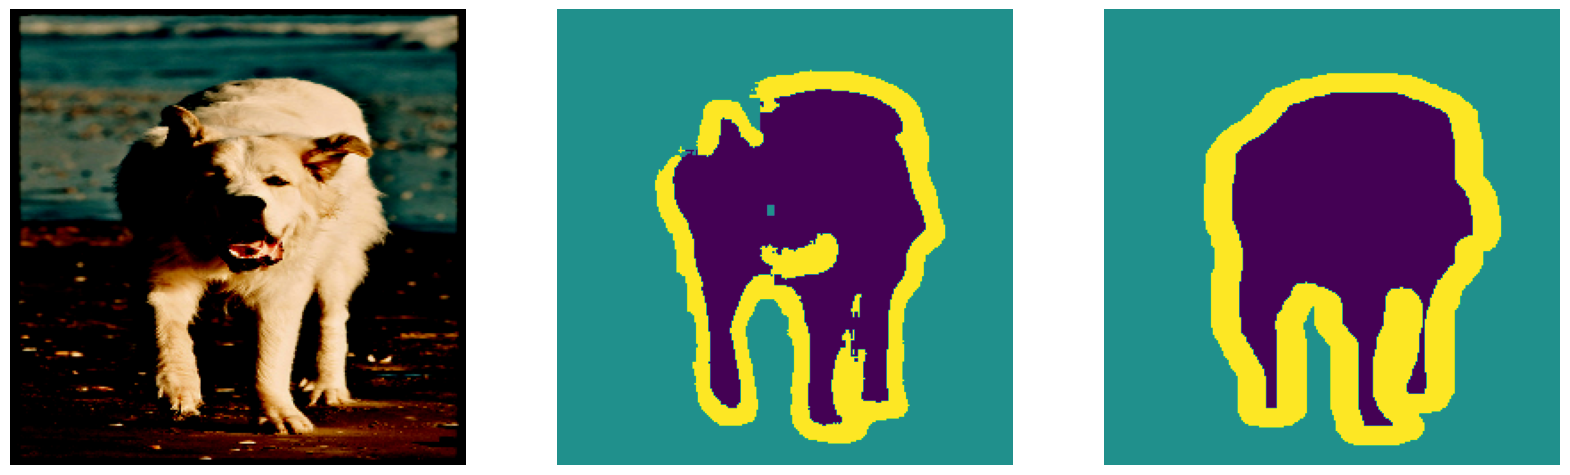

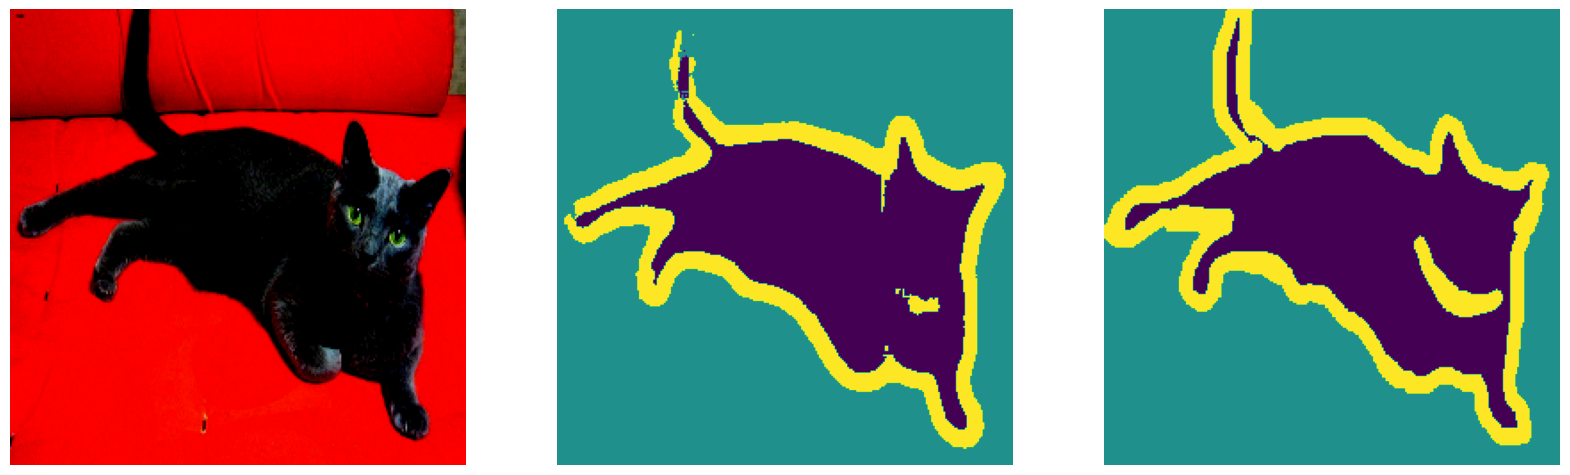

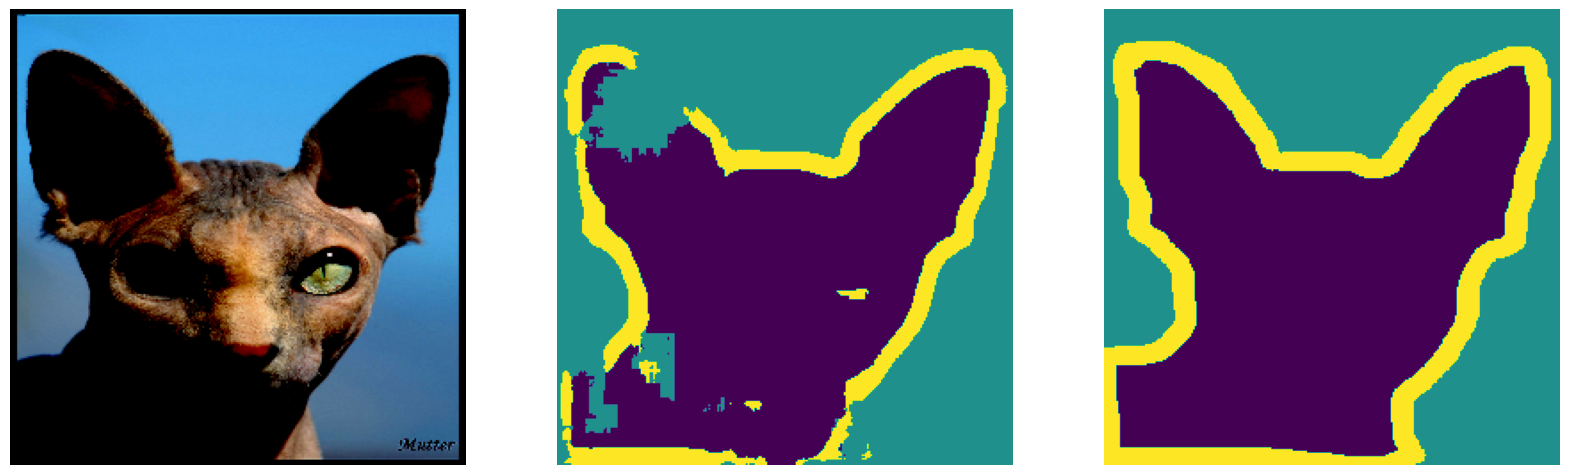

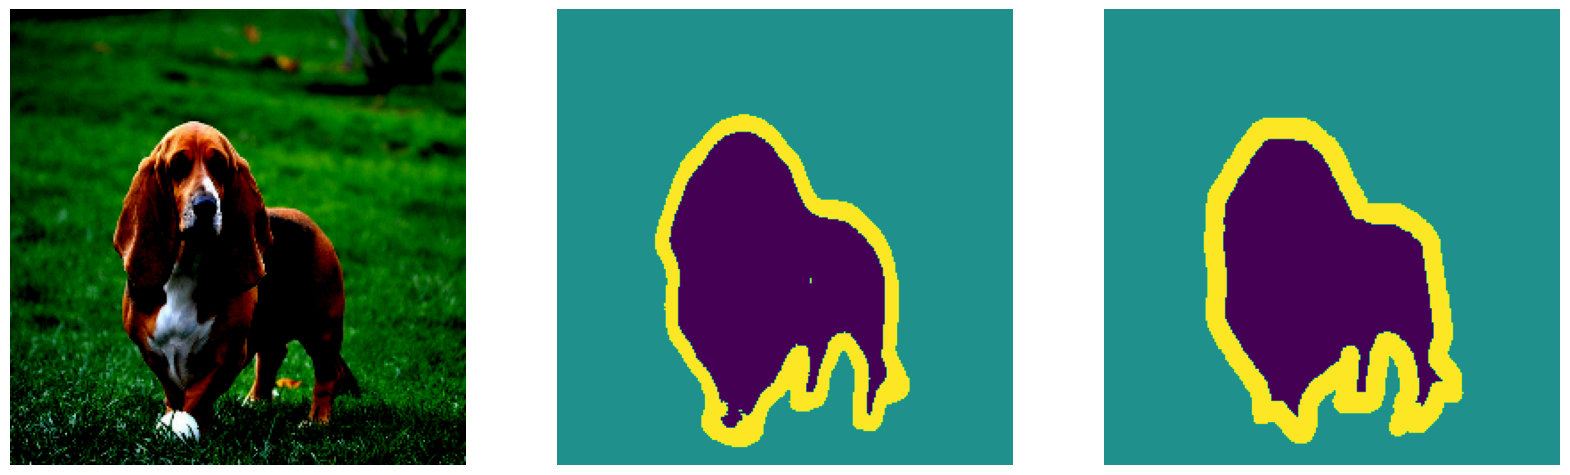

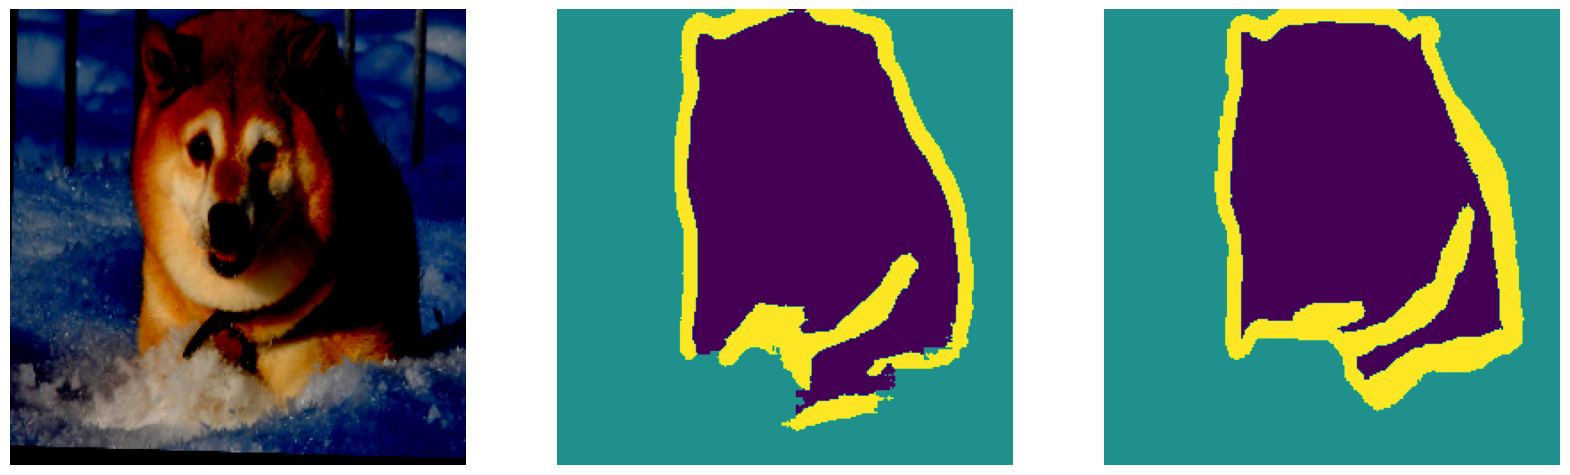

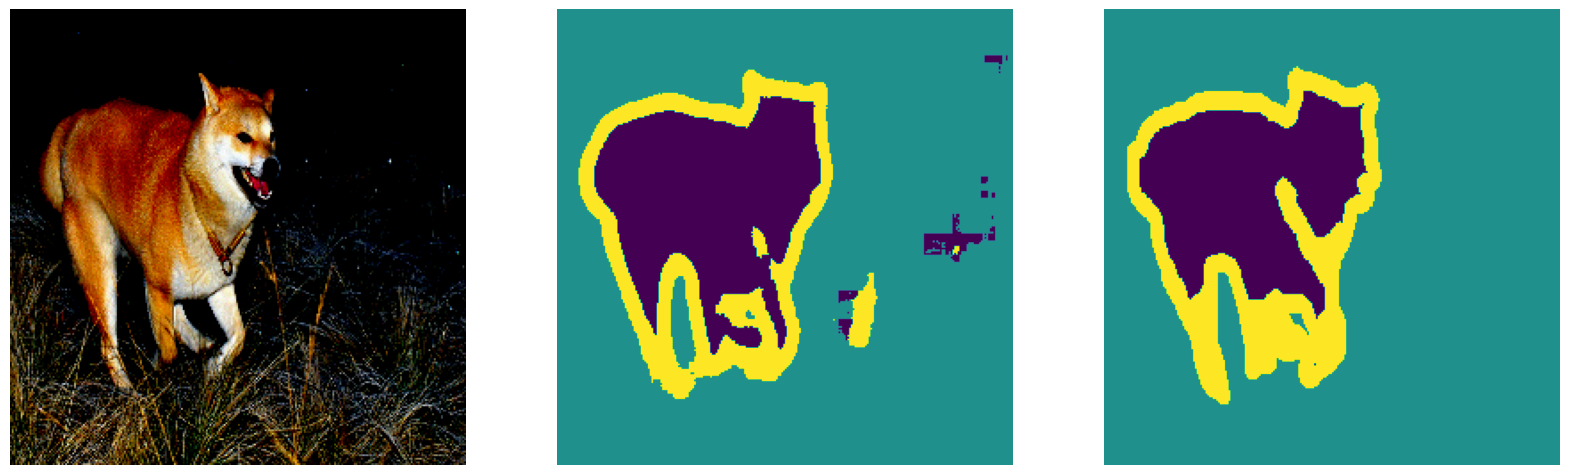

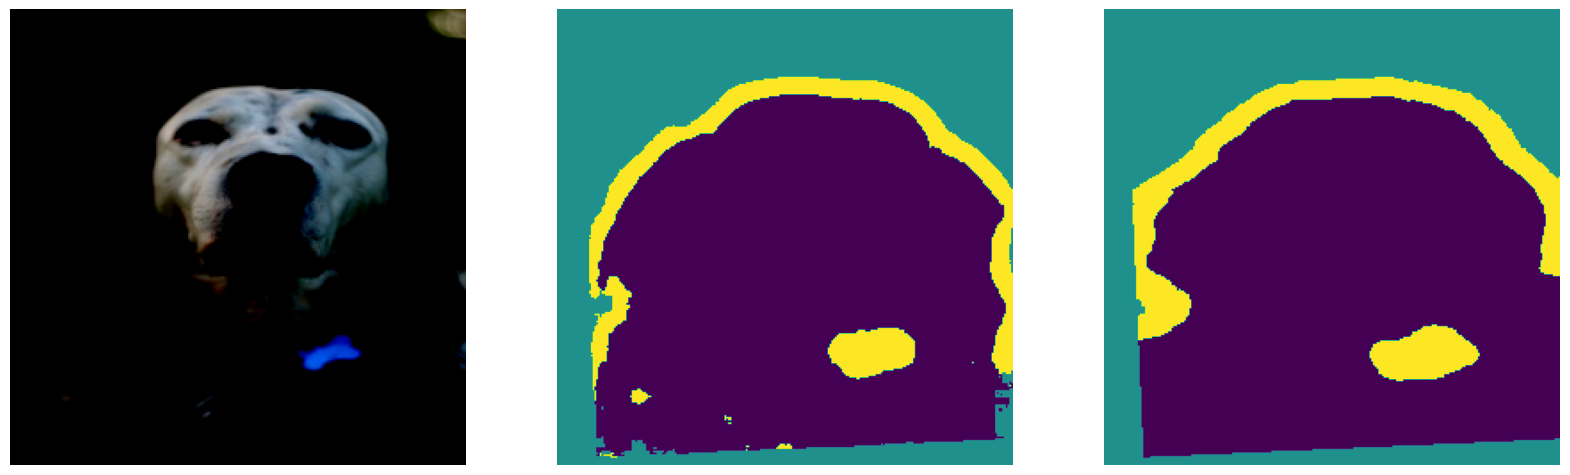

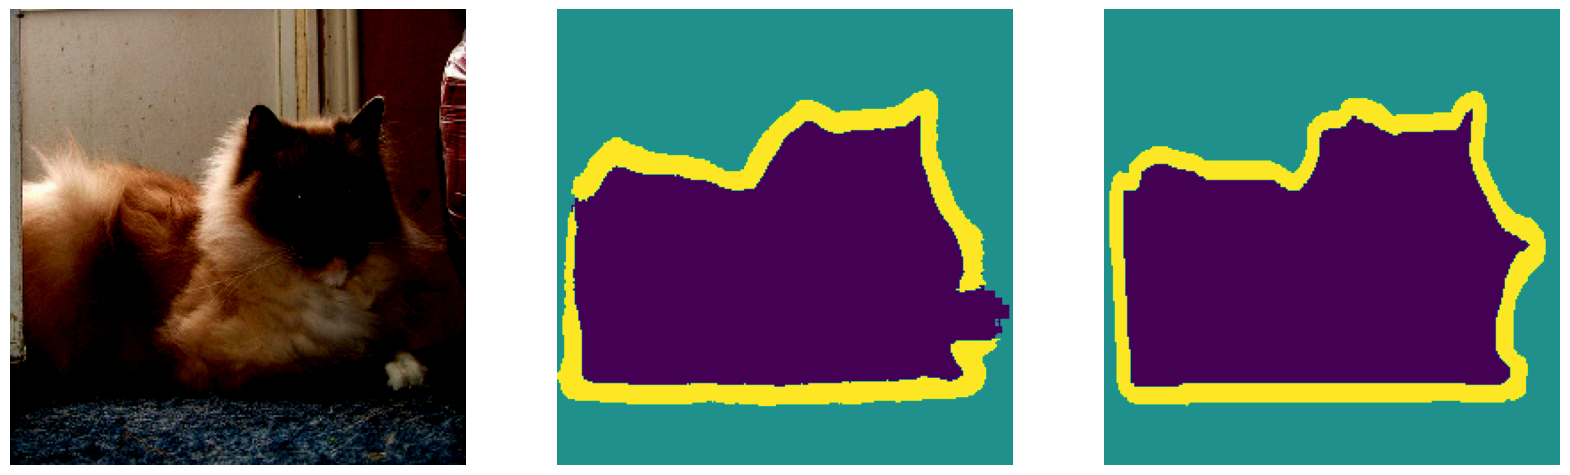

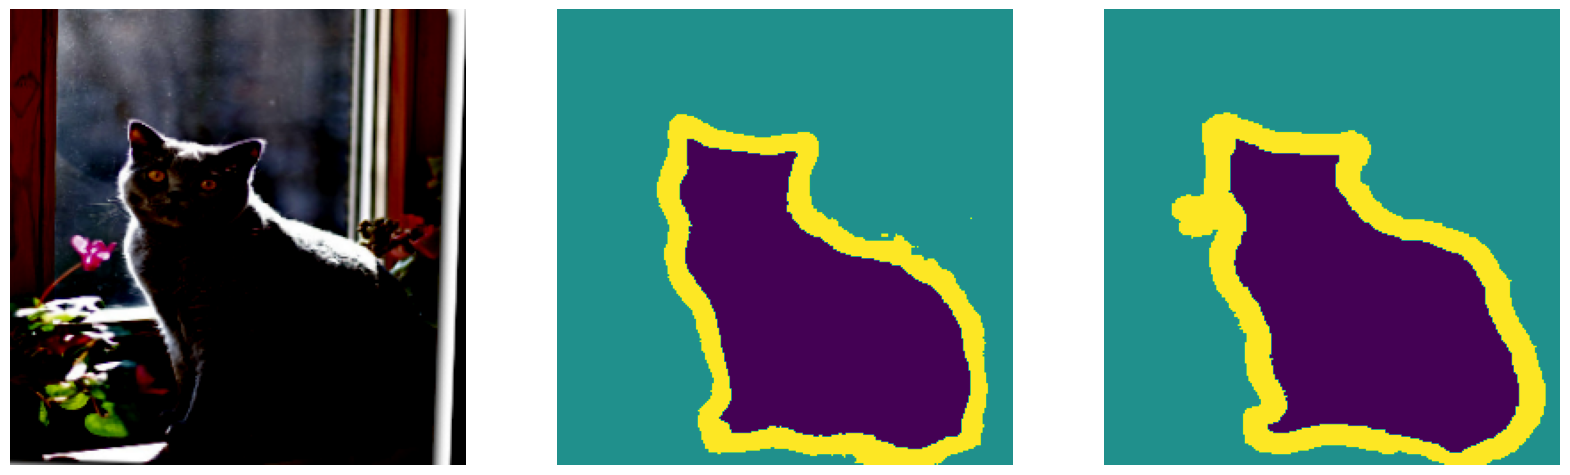

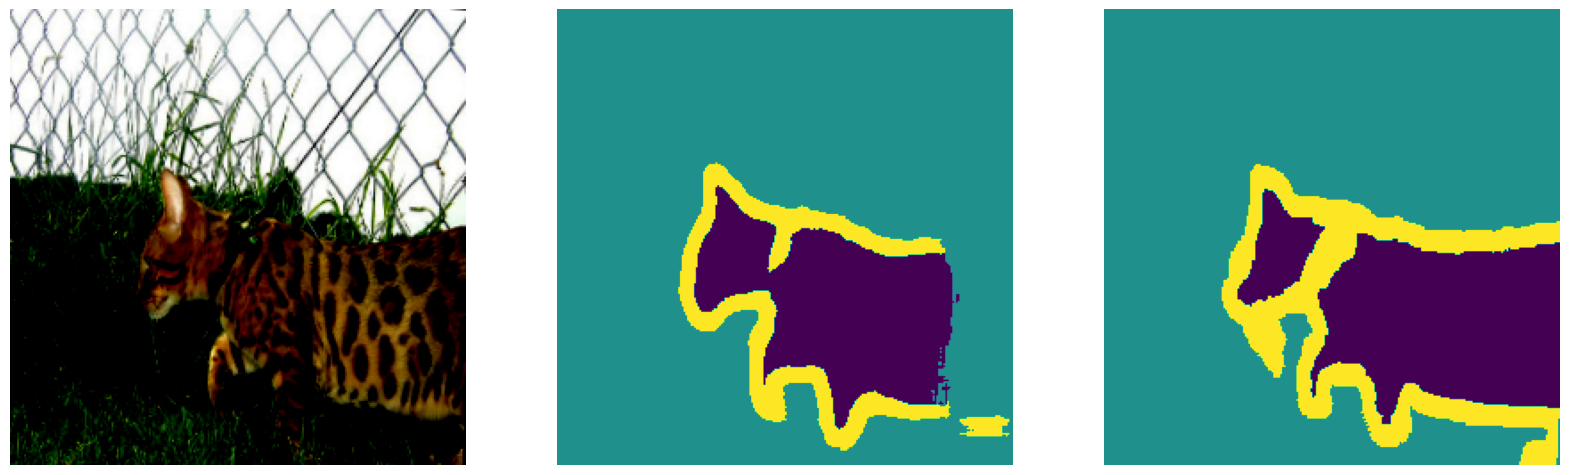

In [14]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        test_img, test_target = test_ds[test_case_idx]
        test_img = test_img.unsqueeze(dim=0).to(device)
        test_msk = test_target['semantic']
        
        _, gen_mask = model(test_img)     
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(test_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(test_msk, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')